In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cm
import cubehelix
from scipy import stats
import matplotlib as mpl
import smact.core as core
from scipy.optimize import curve_fit
S = core.Species('S',-2,'6_n')
O = core.Species('O',-2,'6_n')
Se = core.Species('Se',-2,'6_n')
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

In [121]:
f = open('bulk_props.dat','r')
data = f.readlines()
f.close()
lattice = []; strain = []; epsH = []; eps = []; dip = []; IP = [];IPB = []; eNeg = []; iarea = []; sdipole = []; vbm = []; no_anions = []
for line in data:
    inp = line.split()
    if inp[0] != 'a':
        lattice.append(float(inp[0]))
        strain.append(float(inp[1]))
        epsH.append(float(inp[2]))
        eps.append(float(inp[3]))
        dip.append(float(inp[4]))
        IP.append(float(inp[5]))
        IPB.append(float(inp[6]))
        eNeg.append((float(inp[7])+1.65)/2)
        #eNeg.append(float(inp[7]) - 1.65)
        iarea.append(1/float(inp[8])) # x2 because there are 2 atoms on the surface this is a density now
        sdipole.append(float(inp[9]))
        vbm.append(float(inp[10]))
        no_anions.append(float(inp[11]))
f = open('extra_species.dat','r')
data = f.readlines()
f.close()
shannon = [O.shannon_radius,S.shannon_radius,Se.shannon_radius,O.shannon_radius,S.shannon_radius,Se.shannon_radius,O.shannon_radius,S.shannon_radius,Se.shannon_radius,O.shannon_radius,S.shannon_radius,O.shannon_radius,Se.shannon_radius,S.shannon_radius,Se.shannon_radius]
for line in data:
    inp = line.split()
    if inp[0] != 'area':
        iarea.append(1./float(inp[0]))
        shannon.append(float(inp[1]))
        eNeg.append((float(inp[2])+float(inp[3]))/2)
        #eNeg.append(float(inp[2])-float(inp[3]))
        sdipole.append(float(inp[4])+ float(inp[5]))
        IP.append(float(inp[4]))
        vbm.append(float(inp[5]))
        no_anions.append(float(inp[6]))
shannon = np.asanyarray(shannon)
shannon = shannon.astype(np.float)

In [122]:
eNeg_slope = -1.2844403845
eNeg_const = 3.51538344426
area_slope = 26.537211322
area_const = -0.8137043444
area_chi_constant = 1.59263689063 
dslope = 8.19254202564 
dintercept = 2.50196540099 

In [123]:
def area_chi_dependence(chi,area):
    return area_chi_constant*(eNeg_slope*chi + eNeg_const)*(area_slope*area + area_const)

In [124]:
def surf_dipole(elec_dipole):
    return dslope*elec_dipole + dintercept

In [125]:
def predicted_dipole(factor,a,const):
    return a*factor + const

In [126]:
factor = []; estimated_IPs = []
for i, pot in enumerate(IP):
    #factor.append(shannon[i]*area_chi_dependence(eNeg[i],iarea[i]))
    factor.append(area_chi_dependence(eNeg[i],iarea[i]))
    estimated_IPs.append(calculated_ionisation_potential(shannon[i],eNeg[i],iarea[i],vbm[i],no_anions[i]))

In [127]:
popt, pcov = curve_fit(predicted_dipole, factor, sdipole)

In [129]:
shannon[15],eNeg[15],iarea[15],vbm[15],no_anions[15]

(2.04, 1.93, 0.03758805000714173, 3.7363, 1.0)

In [130]:
predicted_dipoles = []
for number in factor:
    predicted_dipoles.append(predicted_dipole(number,popt[0],popt[1]))    

In [131]:
predicted_IP = []
for i, dipole in enumerate(predicted_dipoles):
    predicted_IP.append(dipole - vbm[i])

In [132]:
ip_slope, ip_prefactor, r_value, p_value, std_err = stats.linregress(predicted_IP,IP)
print 'k =', ip_slope
print 'C =', ip_prefactor
print 'Standard error =', std_err

k = 0.209406259109
C = 4.04525957904
Standard error = 0.0175998850746


In [133]:
corrected_IP = []
for I in predicted_IP:
    corrected_IP.append(ip_slope*I + ip_prefactor)

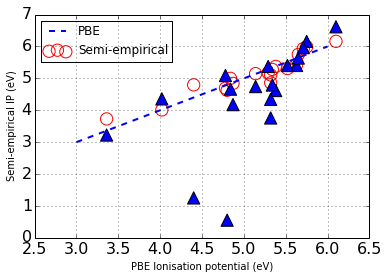

In [134]:
plt.scatter(IP,corrected_IP,marker='o',s=150,facecolors='none',edgecolors='r',label='Semi-empirical')
plt.scatter(IP,estimated_IPs,marker='^',s=150)
eyeline_x=np.arange(3,7)
plt.plot(eyeline_x,eyeline_x,'--',lw=2,label='PBE')
plt.xlabel('PBE Ionisation potential (eV)')
plt.ylabel('Semi-empirical IP (eV)')
plt.legend()
plt.legend(loc=2, fontsize=12)
plt.grid(True)

In [135]:
def calculated_ionisation_potential(shann,av_chi,inv_area,eigen,noanions):
    '''
    shannon - the shannon radius of the anion
    av_chi - the average of anion and cation IP
    inv_area - the inverse surface area
    eigen - the bulk vbm eigenvalue
    '''
    #factor = shann*area_chi_dependence(av_chi,inv_area)
    factor = area_chi_dependence(av_chi,inv_area*noanions)
    estimated_dipole = predicted_dipole(factor,popt[0],popt[1])
    surface_dipole = surf_dipole(factor)/noanions
    #print 'Electric dipole:', factor
    #print 'Surface dipole:', surface_dipole
    #print 'Fitted dipole:', estimated_dipole
    #return ip_slope*(surface_dipole - eigen) + ip_prefactor
    return surface_dipole - eigen
    

In [136]:
print area_chi_dependence((3.44+0.91)/2,0.07)
print calculated_ionisation_potential(1.42,(3.44+0.91)/2,1/27.87,2.86,2)

1.19990805904
3.52626035856


## Test against materials not in the fitting (I. Zincblende semniconductors)

In [137]:
f = open('zb_test_set.dat','r')
data = f.readlines()
f.close()
zb_spec = [];zb_shannon = []; zb_av_chi = []; zb_iarea =[]; zb_eps = []; zb_IP_PBE = []; zb_noanions = []
for line in data:
    inp = line.split()
    if inp[0] != '#':
        zb_spec.append((inp[0]))
        zb_shannon.append(float(inp[1]))
        zb_av_chi.append(((float(inp[2])+float(inp[3])))/2)
        zb_iarea.append(1/float(inp[4]))
        zb_eps.append(float(inp[5]))
        zb_IP_PBE.append(float(inp[6]))
        zb_noanions.append(float(inp[7]))

In [138]:
zb_test_IPs = []
for i, ra in enumerate(zb_shannon):
    zb_test_IPs.append(calculated_ionisation_potential(ra,zb_av_chi[i],zb_iarea[i],zb_eps[i],zb_noanions[i]))

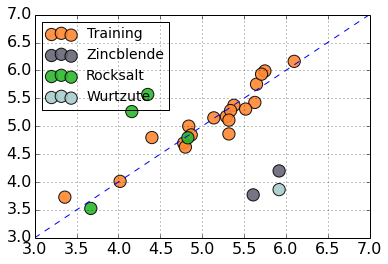

In [139]:
fig, ax1 = plt.subplots()
ax1.set_color_cycle(['#ff8833', '#666677', '#aacccc', '#996655'])
ax1.scatter(IP,corrected_IP,marker='o',s=150,alpha=0.9,label='Training',c='#ff8833')
ax1.scatter(zb_IP_PBE[2:10],zb_test_IPs[2:10],marker='o',s=150,alpha=0.9,label='Zincblende',c='#666677')
ax1.scatter(zb_IP_PBE[10:14],zb_test_IPs[10:14],marker='o',s=150,alpha=0.9,label='Rocksalt',c='#2EB82E')
ax1.scatter(zb_IP_PBE[14],zb_test_IPs[14],marker='o',s=150,alpha=0.9,label='Wurtzute',c='#aacccc')
#plt.scatter(zb_IP_PBE[12:],zb_test_IPs[12:],marker='o',s=150,alpha=0.7,label='Elemental')
eyeline_x=np.arange(3,8)
ax1.plot(eyeline_x,eyeline_x,'--',c='b')
plt.legend()
plt.xlim(3,7)
plt.ylim(3,7)
plt.legend(loc=2, fontsize=14)
plt.grid(True)